# IMPORTS

In [21]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, pickle
import types
from collections import OrderedDict
device = torch.device("cuda")
print(device)

cuda


In [22]:
model_cifar10 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True).to(device)
model_cifar100 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg16_bn", pretrained=True).to(device)

Using cache found in /home/foxunderground/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/foxunderground/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [23]:
from torch.profiler import profile, ProfilerActivity

model_cifar10.eval()
inputs = torch.randn(256, 3, 32, 32).to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU]) as prof:
    with torch.no_grad():
        model_cifar10(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

model_cifar100.eval()
inputs = torch.randn(256, 3, 32, 32).to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU]) as prof:
    with torch.no_grad():
        model_cifar100(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            cudaDeviceSynchronize        78.30%      15.772ms        78.30%      15.772ms      15.772ms             1  
                                     aten::conv2d         0.16%      32.980us        12.23%       2.464ms     189.564us            13  
                                aten::convolution         0.32%      65.309us        12.07%       2.431ms     187.027us            13  
                               aten::_convolution         0.82%     164.699us        11.75%       2.366ms     182.004us            13  
                                 cudaLaunchKerne

In [15]:
transform_train_c10 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010))
])

transform_test_c10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset_c10 = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform_train_c10)
testset_c10 = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform_test_c10)
trainloader_c10 = DataLoader(trainset_c10, batch_size=64, shuffle=True, num_workers=0)
testloader_c10 = DataLoader(testset_c10, batch_size=64, shuffle=False, num_workers=0)

In [16]:
mean_c100 = [0.5070, 0.4865, 0.4409]
std_c100 = [0.2673, 0.2564, 0.2761]

train_transform_c100 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_c100, std_c100)
])

test_transform_c100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_c100, std_c100)
])

trainset_c100 = torchvision.datasets.CIFAR100(root="./data/cifar100", train=True, download=True, transform=train_transform_c100)
testset_c100 = torchvision.datasets.CIFAR100(root="./data/cifar100", train=False, download=True, transform=test_transform_c100)

trainloader_c100 = DataLoader(trainset_c100, batch_size=64, shuffle=True, num_workers=0)
testloader_c100 = DataLoader(testset_c100, batch_size=64, shuffle=False, num_workers=0)

# Testing - CIFAR10

In [11]:
def test_accuracy(model, loader, max_batches=None):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            if max_batches and i >= max_batches: break
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

In [12]:
prunable = []
for name, param in model_cifar10.named_parameters():
    if "weight" in name and param.dim() >= 2:
        prunable.append((name, param))
print(f"{len(prunable)} prunable layers found")


16 prunable layers found


In [13]:
sweep = [0, 10, 20, 50, 70, 80, 90]
sensitivity = {name: [] for name, _ in prunable}

base_acc = test_accuracy(model_cifar10, testloader_c10)
print("Baseline Accuracy:", base_acc)

for name, param in prunable:
    print("\nLayer:", name)
    original = param.data.clone()
    flat = original.abs().view(-1)
    k = len(flat)

    for s in sweep:
        if s == 0:
            param.data.copy_(original)
            acc = test_accuracy(model_cifar10, testloader_c10, max_batches=50)
            sensitivity[name].append(acc)
            print(f"  {s}% -> {acc:.2f}")
            continue

        n_prune = int(k * s / 100)
        if n_prune == 0:
            threshold = 0
        else:
            # move to cpu to use kthvalue since im on mps
            threshold = flat.cpu().kthvalue(n_prune).values.item()

        mask = (original.abs() > threshold).float()
        param.data = original * mask

        acc = test_accuracy(model_cifar10, testloader_c10, max_batches=50)
        sensitivity[name].append(acc)
        print(f"  {s}% -> {acc:.2f}")

    param.data.copy_(original)


Baseline Accuracy: 94.16

Layer: features.0.weight
  0% -> 93.81
  10% -> 93.78
  20% -> 93.84
  50% -> 93.72
  70% -> 92.38
  80% -> 89.19
  90% -> 82.84

Layer: features.3.weight
  0% -> 93.81
  10% -> 93.81
  20% -> 93.81
  50% -> 93.69
  70% -> 93.28
  80% -> 92.53
  90% -> 85.81

Layer: features.7.weight
  0% -> 93.81
  10% -> 93.88
  20% -> 93.81
  50% -> 93.41
  70% -> 92.50
  80% -> 90.88
  90% -> 81.25

Layer: features.10.weight
  0% -> 93.81
  10% -> 93.78
  20% -> 93.91
  50% -> 93.41
  70% -> 91.72
  80% -> 87.31
  90% -> 55.28

Layer: features.14.weight
  0% -> 93.81
  10% -> 93.75
  20% -> 93.78
  50% -> 93.53
  70% -> 91.69
  80% -> 82.38
  90% -> 23.78

Layer: features.17.weight
  0% -> 93.81
  10% -> 93.78
  20% -> 93.81
  50% -> 93.78
  70% -> 93.50
  80% -> 91.97
  90% -> 79.81

Layer: features.20.weight
  0% -> 93.81
  10% -> 93.78
  20% -> 93.78
  50% -> 93.84
  70% -> 93.22
  80% -> 92.44
  90% -> 89.44

Layer: features.24.weight
  0% -> 93.81
  10% -> 93.81
  20%

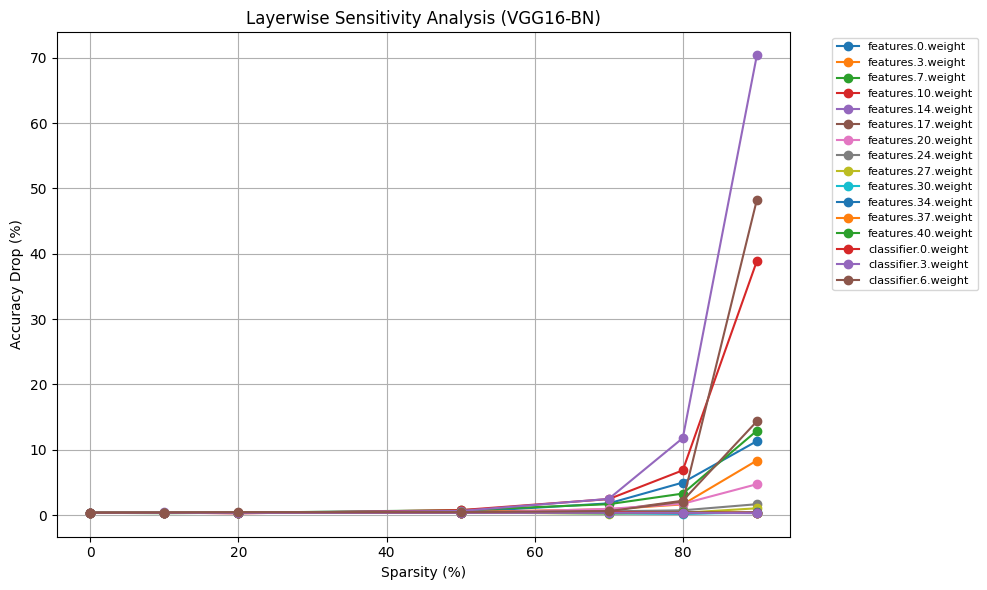

In [14]:
plt.figure(figsize=(10, 6))
for name, accs in sensitivity.items():
    drops = [base_acc - a for a in accs]
    plt.plot(sweep, drops, marker='o', label=name)
plt.xlabel("Sparsity (%)")
plt.ylabel("Accuracy Drop (%)")
plt.title("Layerwise Sensitivity Analysis (VGG16-BN)")
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
sweep_percent = [0, 10, 20, 50, 70, 80, 90]

DROP_TINY = 0.5
DROP_MODERATE = 1.5
per_layer_sparsity = OrderedDict()

param_counts = {name: param.numel() for name, param in prunable}
total_params = sum(param_counts.values())
for name, _ in prunable:
    accs = np.array(sensitivity[name])
    baseline = accs[0]
    try:
        idx20 = sweep_percent.index(20)
        idx50 = sweep_percent.index(50)
    except ValueError:
        idx20 = 2
        idx50 = 3
    drop20 = baseline - accs[idx20]
    drop50 = baseline - accs[idx50]

    if drop20 <= DROP_TINY and drop50 <= 1.0:
        chosen = 0.7
    elif drop20 <= DROP_MODERATE and drop50 <= 3.0:
        chosen = 0.5
    else:
        chosen = 0.1
    per_layer_sparsity[name] = chosen

nonzeros_expected = sum((1.0 - per_layer_sparsity[n]) * param_counts[n] for n in per_layer_sparsity)
overall_sparsity = 1.0 - (nonzeros_expected / total_params)

print("Per-layer chosen sparsity (percent):")
for n, s in per_layer_sparsity.items():
    print(f"  {n:40s}: {int(round(s*100)):3d}%  (params={param_counts[n]:7d})")
print(f"\nExpected overall sparsity: {overall_sparsity*100:.2f}% of prunable params\n")


Per-layer chosen sparsity (percent):
  features.0.weight                       :  70%  (params=   1728)
  features.3.weight                       :  70%  (params=  36864)
  features.7.weight                       :  70%  (params=  73728)
  features.10.weight                      :  70%  (params= 147456)
  features.14.weight                      :  70%  (params= 294912)
  features.17.weight                      :  70%  (params= 589824)
  features.20.weight                      :  70%  (params= 589824)
  features.24.weight                      :  70%  (params=1179648)
  features.27.weight                      :  70%  (params=2359296)
  features.30.weight                      :  70%  (params=2359296)
  features.34.weight                      :  70%  (params=2359296)
  features.37.weight                      :  70%  (params=2359296)
  features.40.weight                      :  70%  (params=2359296)
  classifier.0.weight                     :  70%  (params= 262144)
  classifier.3.weight    

In [16]:
masks = {}
total_params, total_nonzero = 0, 0

for name, param in model_cifar10.named_parameters():
    if not any(k in name for k in ["weight"]):
        continue
    if name not in per_layer_sparsity:
        continue
    s = per_layer_sparsity[name]
    flat = param.data.view(-1)
    n_prune = int(flat.numel() * s)
    if n_prune > 0:
        flat_cpu = flat.detach().cpu()
        threshold = flat_cpu.abs().kthvalue(n_prune).values.item()
        mask = (flat_cpu.abs() > threshold).float().to(param.device)
    else:
        mask = torch.ones_like(flat)
    mask = mask.view_as(param.data)
    masks[name] = mask
    param.data.mul_(mask)
    total_params += mask.numel()
    total_nonzero += mask.sum().item()

actual_sparsity = 1 - total_nonzero / total_params
print(f"Applied pruning. Actual overall sparsity: {actual_sparsity*100:.2f}%")


Applied pruning. Actual overall sparsity: 70.00%


In [17]:
os.makedirs("checkpoints/cifar10", exist_ok=True)
with open("checkpoints//cifar10/pruning_masks.pkl", "wb") as f:
    pickle.dump(masks, f)
print("Saved pruning masks.")


Saved pruning masks.


In [18]:
epochs = 5
lr = 1e-3
optimizer = torch.optim.SGD(model_cifar10.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model_cifar10.train()
for epoch in range(epochs):
    running_loss, correct, total = 0, 0, 0
    for x, y in tqdm(trainloader_c10, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model_cifar10(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for n, p in model_cifar10.named_parameters():
                if n in masks:
                    p.mul_(masks[n])

        running_loss += loss.item()
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()
    print(f"Epoch {epoch+1}: Loss={running_loss/len(trainloader_c10):.4f}, Acc={(100*correct/total):.2f}%")

torch.save(model_cifar10.state_dict(), "checkpoints/cifar10/vgg16bn_cifar10_pruned_finetuned.pth")


Fine-tuning Epoch 1/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: Loss=0.3577, Acc=91.27%


Fine-tuning Epoch 2/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: Loss=0.2749, Acc=92.72%


Fine-tuning Epoch 3/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: Loss=0.2451, Acc=93.30%


Fine-tuning Epoch 4/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: Loss=0.2191, Acc=94.33%


Fine-tuning Epoch 5/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: Loss=0.2014, Acc=94.51%


In [20]:
state_dict = torch.load("checkpoints/cifar10/vgg16bn_cifar10_pruned_finetuned.pth", map_location="cuda")
model_cifar10.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
# Convert to sparse COO format
sparse_weights = {}
for name, param in model_cifar10.named_parameters():
    if name in masks:
        sparse_tensor = param.to_dense() if param.is_sparse else param
        sparse_tensor = sparse_tensor.to("cpu")
        sparse_coo = sparse_tensor.to_sparse_coo()
        sparse_weights[name] = sparse_coo
        mask_flat = masks[name].flatten().cpu().numpy()
        coo_flat = torch.zeros_like(param).flatten()
        if sparse_coo._nnz() > 0:
            idx = sparse_coo.indices()
            coo_flat[idx[0]] = 1
        nonzero_mask = mask_flat.sum()
        nonzero_coo = sparse_coo._nnz()
        print(f"{name}: mask_nonzero={nonzero_mask}, coo_nonzero={nonzero_coo}")

features.0.weight: mask_nonzero=519.0, coo_nonzero=519
features.3.weight: mask_nonzero=11060.0, coo_nonzero=11060
features.7.weight: mask_nonzero=22119.0, coo_nonzero=22119
features.10.weight: mask_nonzero=44237.0, coo_nonzero=44237
features.14.weight: mask_nonzero=88474.0, coo_nonzero=88474
features.17.weight: mask_nonzero=176948.0, coo_nonzero=176948
features.20.weight: mask_nonzero=176948.0, coo_nonzero=176948
features.24.weight: mask_nonzero=353895.0, coo_nonzero=353895
features.27.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.30.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.34.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.37.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.40.weight: mask_nonzero=707789.0, coo_nonzero=707789
classifier.0.weight: mask_nonzero=78644.0, coo_nonzero=78644
classifier.3.weight: mask_nonzero=78644.0, coo_nonzero=78644
classifier.6.weight: mask_nonzero=1536.0, coo_nonzero=1536


In [22]:
class SparseLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        w_sparse = self.weight.to_sparse()
        out = torch.sparse.mm(w_sparse, x.T).T
        if self.bias is not None:
            out = out + self.bias
        return out

def convert_to_sparse_linear(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            new_layer = SparseLinear(module.in_features, module.out_features, bias=(module.bias is not None))
            with torch.no_grad():
                new_layer.weight.copy_(module.weight)
                if module.bias is not None:
                    new_layer.bias.copy_(module.bias)
            setattr(model, name, new_layer)
        else:
            convert_to_sparse_linear(module)
    return model

model_cifar10 = convert_to_sparse_linear(model_cifar10)

In [23]:
for name, param in model_cifar10.named_parameters():
    if 'weight' in name:
        cpu_tensor = param.detach().to("cpu")
        w_sparse = cpu_tensor.to_sparse()
        mask = (cpu_tensor != 0).float()
        indices = w_sparse.indices()
        print(f"{name}: {indices.shape[1]} nonzero weights, matches mask sum {mask.sum().item()}")

features.0.weight: 519 nonzero weights, matches mask sum 519.0
features.1.weight: 64 nonzero weights, matches mask sum 64.0
features.3.weight: 11060 nonzero weights, matches mask sum 11060.0
features.4.weight: 64 nonzero weights, matches mask sum 64.0
features.7.weight: 22119 nonzero weights, matches mask sum 22119.0
features.8.weight: 128 nonzero weights, matches mask sum 128.0
features.10.weight: 44237 nonzero weights, matches mask sum 44237.0
features.11.weight: 128 nonzero weights, matches mask sum 128.0
features.14.weight: 88474 nonzero weights, matches mask sum 88474.0
features.15.weight: 256 nonzero weights, matches mask sum 256.0
features.17.weight: 176948 nonzero weights, matches mask sum 176948.0
features.18.weight: 256 nonzero weights, matches mask sum 256.0
features.20.weight: 176948 nonzero weights, matches mask sum 176948.0
features.21.weight: 256 nonzero weights, matches mask sum 256.0
features.24.weight: 353895 nonzero weights, matches mask sum 353895.0
features.25.weig

In [24]:
device = torch.device("cpu")  # override MPS for sparse inference
model_cifar10 = model_cifar10.to(device)

def test_accuracy(model, loader, max_batches=None):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        loop = tqdm(enumerate(loader), total=min(len(loader), max_batches) if max_batches else len(loader), leave=False)
        for i, (x, y) in loop:
            if max_batches and i >= max_batches:
                break
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            loop.set_description(f"Accuracy: {100 * correct / total:.2f}%")
    return 100 * correct / total

print("Running sparse inference on CPU (MPS not supported for sparse ops)...")
model_cifar10.eval()
with torch.no_grad():
    acc = test_accuracy(model_cifar10, testloader_c10, max_batches=50)
print(f"Sparse inference accuracy: {acc:.2f}%")


Running sparse inference on CPU (MPS not supported for sparse ops)...


  0%|          | 0/50 [00:00<?, ?it/s]

Sparse inference accuracy: 96.25%


In [25]:
from torch.profiler import profile, ProfilerActivity

model_cifar10.eval()
inputs = torch.randn(256, 3, 32, 32).to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU]) as prof:
    with torch.no_grad():
        model_cifar10(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::conv2d         0.00%      93.996us        87.39%        2.939s     226.107ms            13  
                                 aten::convolution         0.01%     214.287us        87.38%        2.939s     226.100ms            13  
                                aten::_convolution         0.01%     313.892us        87.38%        2.939s     226.083ms            13  
                          aten::mkldnn_convolution        87.35%        2.938s        87.37%        2.939s     226.059ms            13  
                                  aten::m

# Testing - CIFAR100

In [29]:
def test_accuracy(model, loader, max_batches=None):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            if max_batches and i >= max_batches: break
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

In [30]:
device = torch.device("cuda")
model_cifar100.eval()
prunable = []
for name, param in model_cifar100.named_parameters():
    if "weight" in name and param.dim() >= 2:
        prunable.append((name, param))
print(f"{len(prunable)} prunable layers found")


16 prunable layers found


In [31]:
sweep = [0, 10, 20, 50, 70, 80, 90]
sensitivity = {name: [] for name, _ in prunable}

base_acc = test_accuracy(model_cifar100, testloader_c100)
print("Baseline Accuracy:", base_acc)

for name, param in prunable:
    print("\nLayer:", name)
    original = param.data.clone()
    flat = original.abs().view(-1)
    k = len(flat)

    for s in sweep:
        if s == 0:
            param.data.copy_(original)
            acc = test_accuracy(model_cifar100, testloader_c100, max_batches=50)
            sensitivity[name].append(acc)
            print(f"  {s}% -> {acc:.2f}")
            continue

        n_prune = int(k * s / 100)
        if n_prune == 0:
            threshold = 0
        else:
            # move to cpu to use kthvalue since im on mps
            threshold = flat.cpu().kthvalue(n_prune).values.item()

        mask = (original.abs() > threshold).float()
        param.data = original * mask

        acc = test_accuracy(model_cifar100, testloader_c100, max_batches=50)
        sensitivity[name].append(acc)
        print(f"  {s}% -> {acc:.2f}")

    param.data.copy_(original)


Baseline Accuracy: 74.0

Layer: features.0.weight
  0% -> 73.53
  10% -> 73.53
  20% -> 73.62
  50% -> 73.50
  70% -> 70.75
  80% -> 68.81
  90% -> 56.28

Layer: features.3.weight
  0% -> 73.53
  10% -> 73.53
  20% -> 73.53
  50% -> 73.44
  70% -> 71.28
  80% -> 68.69
  90% -> 60.09

Layer: features.7.weight
  0% -> 73.53
  10% -> 73.41
  20% -> 73.47
  50% -> 73.53
  70% -> 71.09
  80% -> 66.78
  90% -> 46.44

Layer: features.10.weight
  0% -> 73.53
  10% -> 73.66
  20% -> 73.59
  50% -> 73.38
  70% -> 69.16
  80% -> 59.47
  90% -> 29.94

Layer: features.14.weight
  0% -> 73.53
  10% -> 73.62
  20% -> 73.75
  50% -> 72.62
  70% -> 68.53
  80% -> 54.06
  90% -> 12.75

Layer: features.17.weight
  0% -> 73.53
  10% -> 73.50
  20% -> 73.34
  50% -> 73.66
  70% -> 71.03
  80% -> 64.19
  90% -> 19.44

Layer: features.20.weight
  0% -> 73.53
  10% -> 73.56
  20% -> 73.47
  50% -> 73.06
  70% -> 69.81
  80% -> 61.81
  90% -> 35.03

Layer: features.24.weight
  0% -> 73.53
  10% -> 73.53
  20% 

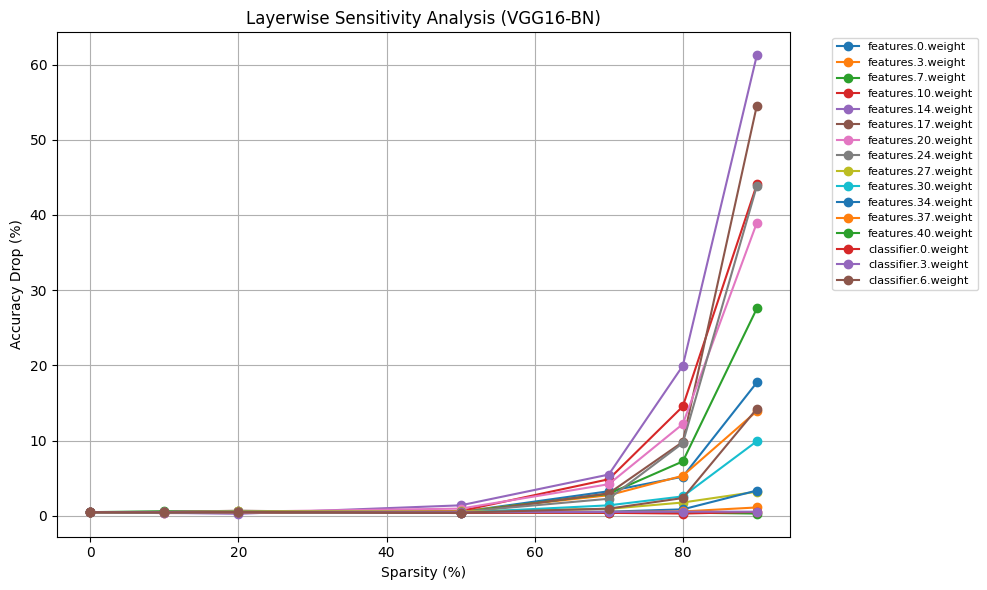

In [32]:
plt.figure(figsize=(10, 6))
for name, accs in sensitivity.items():
    drops = [base_acc - a for a in accs]
    plt.plot(sweep, drops, marker='o', label=name)
plt.xlabel("Sparsity (%)")
plt.ylabel("Accuracy Drop (%)")
plt.title("Layerwise Sensitivity Analysis (VGG16-BN)")
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
sweep_percent = [0, 10, 20, 50, 70, 80, 90]

DROP_TINY = 0.5
DROP_MODERATE = 1.5
per_layer_sparsity = OrderedDict()
param_counts = {name: param.numel() for name, param in prunable}
total_params = sum(param_counts.values())

for name, _ in prunable:
    accs = np.array(sensitivity[name])
    baseline = accs[0]
    try:
        idx20 = sweep_percent.index(20)
        idx50 = sweep_percent.index(50)
    except ValueError:
        idx20 = 2
        idx50 = 3

    drop20 = baseline - accs[idx20]
    drop50 = baseline - accs[idx50]

    if drop20 <= DROP_TINY and drop50 <= 1.0:
        chosen = 0.7
    elif drop20 <= DROP_MODERATE and drop50 <= 3.0:
        chosen = 0.5
    else:
        chosen = 0.1

    per_layer_sparsity[name] = chosen

nonzeros_expected = sum((1.0 - per_layer_sparsity[n]) * param_counts[n] for n in per_layer_sparsity)
overall_sparsity = 1.0 - (nonzeros_expected / total_params)

print("Per-layer chosen sparsity (percent):")
for n, s in per_layer_sparsity.items():
    print(f"  {n:40s}: {int(round(s*100)):3d}%  (params={param_counts[n]:7d})")
print(f"\nExpected overall sparsity: {overall_sparsity*100:.2f}% of prunable params\n")


Per-layer chosen sparsity (percent):
  features.0.weight                       :  70%  (params=   1728)
  features.3.weight                       :  70%  (params=  36864)
  features.7.weight                       :  70%  (params=  73728)
  features.10.weight                      :  70%  (params= 147456)
  features.14.weight                      :  70%  (params= 294912)
  features.17.weight                      :  70%  (params= 589824)
  features.20.weight                      :  70%  (params= 589824)
  features.24.weight                      :  70%  (params=1179648)
  features.27.weight                      :  70%  (params=2359296)
  features.30.weight                      :  70%  (params=2359296)
  features.34.weight                      :  70%  (params=2359296)
  features.37.weight                      :  70%  (params=2359296)
  features.40.weight                      :  70%  (params=2359296)
  classifier.0.weight                     :  70%  (params= 262144)
  classifier.3.weight    

In [34]:
masks = {}
total_params, total_nonzero = 0, 0

for name, param in model_cifar100.named_parameters():
    if not any(k in name for k in ["weight"]):
        continue
    if name not in per_layer_sparsity:
        continue
    s = per_layer_sparsity[name]
    flat = param.data.view(-1)
    n_prune = int(flat.numel() * s)
    if n_prune > 0:
        flat_cpu = flat.detach().cpu()
        threshold = flat_cpu.abs().kthvalue(n_prune).values.item()
        mask = (flat_cpu.abs() > threshold).float().to(param.device)
    else:
        mask = torch.ones_like(flat)
    mask = mask.view_as(param.data)
    masks[name] = mask
    param.data.mul_(mask)
    total_params += mask.numel()
    total_nonzero += mask.sum().item()

actual_sparsity = 1 - total_nonzero / total_params
print(f"Applied pruning. Actual overall sparsity: {actual_sparsity*100:.2f}%")


Applied pruning. Actual overall sparsity: 70.00%


In [35]:
os.makedirs("checkpoints/cifar100", exist_ok=True)
with open("checkpoints/cifar100/pruning_masks.pkl", "wb") as f:
    pickle.dump(masks, f)
print("Saved pruning masks.")


Saved pruning masks.


In [36]:
epochs = 5
lr = 1e-3
optimizer = torch.optim.SGD(model_cifar100.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model_cifar100.train()
for epoch in range(epochs):
    running_loss, correct, total = 0, 0, 0
    for x, y in tqdm(trainloader_c100, desc=f"Fine-tuning Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model_cifar100(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for n, p in model_cifar100.named_parameters():
                if n in masks:
                    p.mul_(masks[n])

        running_loss += loss.item()
        _, pred = out.max(1)
        total += y.size(0)
        correct += pred.eq(y).sum().item()
    print(f"Epoch {epoch+1}: Loss={running_loss/len(trainloader_c100):.4f}, Acc={(100*correct/total):.2f}%")

torch.save(model_cifar100.state_dict(), "checkpoints/cifar100/vgg16bn_cifar10_pruned_finetuned.pth")
print("Fine-tuned pruned model saved.")


Fine-tuning Epoch 1/5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: Loss=0.2177, Acc=96.51%


Fine-tuning Epoch 2/5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: Loss=0.1244, Acc=97.63%


Fine-tuning Epoch 3/5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: Loss=0.0974, Acc=98.01%


Fine-tuning Epoch 4/5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4: Loss=0.0877, Acc=98.14%


Fine-tuning Epoch 5/5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5: Loss=0.0760, Acc=98.30%
Fine-tuned pruned model saved.


In [38]:
checkpoint_path = "checkpoints/cifar100/vgg16bn_cifar10_pruned_finetuned.pth"
state_dict = torch.load(checkpoint_path, map_location="cuda")
model_cifar100.load_state_dict(state_dict)

<All keys matched successfully>

In [39]:
sparse_weights = {}
for name, param in model_cifar100.named_parameters():
    if name in masks:
        sparse_tensor = param.to_dense() if param.is_sparse else param
        sparse_tensor = sparse_tensor.to("cpu")
        sparse_coo = sparse_tensor.to_sparse_coo()
        sparse_weights[name] = sparse_coo
        mask_flat = masks[name].flatten().cpu().numpy()
        coo_flat = torch.zeros_like(param).flatten()
        if sparse_coo._nnz() > 0:
            idx = sparse_coo.indices()
            coo_flat[idx[0]] = 1
        nonzero_mask = mask_flat.sum()
        nonzero_coo = sparse_coo._nnz()
        print(f"{name}: mask_nonzero={nonzero_mask}, coo_nonzero={nonzero_coo}")


features.0.weight: mask_nonzero=519.0, coo_nonzero=519
features.3.weight: mask_nonzero=11060.0, coo_nonzero=11060
features.7.weight: mask_nonzero=22119.0, coo_nonzero=22119
features.10.weight: mask_nonzero=44237.0, coo_nonzero=44237
features.14.weight: mask_nonzero=88474.0, coo_nonzero=88474
features.17.weight: mask_nonzero=176948.0, coo_nonzero=176948
features.20.weight: mask_nonzero=176948.0, coo_nonzero=176948
features.24.weight: mask_nonzero=353895.0, coo_nonzero=353895
features.27.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.30.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.34.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.37.weight: mask_nonzero=707789.0, coo_nonzero=707789
features.40.weight: mask_nonzero=707789.0, coo_nonzero=707789
classifier.0.weight: mask_nonzero=78644.0, coo_nonzero=78644
classifier.3.weight: mask_nonzero=78644.0, coo_nonzero=78644
classifier.6.weight: mask_nonzero=15360.0, coo_nonzero=15360


In [40]:
class SparseLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        w_sparse = self.weight.to_sparse()
        out = torch.sparse.mm(w_sparse, x.T).T
        if self.bias is not None:
            out = out + self.bias
        return out

def convert_to_sparse_linear(model):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            new_layer = SparseLinear(module.in_features, module.out_features, bias=(module.bias is not None))
            with torch.no_grad():
                new_layer.weight.copy_(module.weight)
                if module.bias is not None:
                    new_layer.bias.copy_(module.bias)
            setattr(model, name, new_layer)
        else:
            convert_to_sparse_linear(module)
    return model

model_cifar100 = convert_to_sparse_linear(model_cifar100)


In [41]:
for name, param in model_cifar100.named_parameters():
    if 'weight' in name:
        cpu_tensor = param.detach().to("cpu")
        w_sparse = cpu_tensor.to_sparse()
        mask = (cpu_tensor != 0).float()
        indices = w_sparse.indices()
        print(f"{name}: {indices.shape[1]} nonzero weights, matches mask sum {mask.sum().item()}")

features.0.weight: 519 nonzero weights, matches mask sum 519.0
features.1.weight: 64 nonzero weights, matches mask sum 64.0
features.3.weight: 11060 nonzero weights, matches mask sum 11060.0
features.4.weight: 64 nonzero weights, matches mask sum 64.0
features.7.weight: 22119 nonzero weights, matches mask sum 22119.0
features.8.weight: 128 nonzero weights, matches mask sum 128.0
features.10.weight: 44237 nonzero weights, matches mask sum 44237.0
features.11.weight: 128 nonzero weights, matches mask sum 128.0
features.14.weight: 88474 nonzero weights, matches mask sum 88474.0
features.15.weight: 256 nonzero weights, matches mask sum 256.0
features.17.weight: 176948 nonzero weights, matches mask sum 176948.0
features.18.weight: 256 nonzero weights, matches mask sum 256.0
features.20.weight: 176948 nonzero weights, matches mask sum 176948.0
features.21.weight: 256 nonzero weights, matches mask sum 256.0
features.24.weight: 353895 nonzero weights, matches mask sum 353895.0
features.25.weig

In [42]:
device = torch.device("cpu")  # override cuda for sparse inference
model_cifar100 = model_cifar100.to(device)

def test_accuracy(model, loader, max_batches=None):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        loop = tqdm(enumerate(loader), total=min(len(loader), max_batches) if max_batches else len(loader), leave=False)
        for i, (x, y) in loop:
            if max_batches and i >= max_batches:
                break
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            loop.set_description(f"Accuracy: {100 * correct / total:.2f}%")
    return 100 * correct / total

print("Running sparse inference on CPU (MPS not supported for sparse ops)...")
model_cifar100.eval()
with torch.no_grad():
    acc = test_accuracy(model_cifar100, testloader_c100, max_batches=50)
print(f"Sparse inference accuracy: {acc:.2f}%")


Running sparse inference on CPU (MPS not supported for sparse ops)...


  0%|          | 0/50 [00:00<?, ?it/s]

Sparse inference accuracy: 72.47%


In [43]:
from torch.profiler import profile, ProfilerActivity

model_cifar100.eval()
inputs = torch.randn(256, 3, 32, 32).to(device)

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU]) as prof:
    with torch.no_grad():
        model_cifar100(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::conv2d         0.00%     109.874us        88.25%        3.198s     245.977ms            13  
                                 aten::convolution         0.01%     215.554us        88.25%        3.198s     245.968ms            13  
                                aten::_convolution         0.01%     304.079us        88.24%        3.197s     245.952ms            13  
                          aten::mkldnn_convolution        88.21%        3.196s        88.23%        3.197s     245.928ms            13  
                                  aten::m

# Final Results

In [24]:
import torch
import time
import io
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetTotalEnergyConsumption
import thop.profile
from torch.profiler import profile, record_function, ProfilerActivity

In [25]:
def evaluate_model_efficiency(model, dataloader, device, runs=100):
    model.to(device)
    model.eval()

    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    nvmlInit()
    gpu = nvmlDeviceGetHandleByIndex(0)
    start_energy = nvmlDeviceGetTotalEnergyConsumption(gpu)

    total_time, total_mem, correct1, correct5 = 0, 0, 0, 0
    for _ in range(runs):
        torch.cuda.reset_peak_memory_stats()
        start_t = time.time()
        with torch.no_grad():
            outputs = model(images)
        torch.cuda.synchronize()
        end_t = time.time()
        total_time += (end_t - start_t) * 1000
        total_mem += torch.cuda.memory_allocated(device) / (1024 ** 2)
        top5_pred = outputs.topk(5, dim=1).indices
        top1_pred = outputs.argmax(dim=1)
        correct1 += (top1_pred == labels).sum().item()
        correct5 += sum(labels[i] in top5_pred[i] for i in range(len(labels)))
    total = len(labels)
    top1_acc = 100 * correct1 / (total * runs)
    top5_acc = 100 * correct5 / (total * runs)

    end_energy = nvmlDeviceGetTotalEnergyConsumption(gpu)
    avg_energy = (end_energy - start_energy) / runs
    avg_latency = total_time / runs
    avg_mem = total_mem / runs
    peak_mem = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

    buf = io.BytesIO()
    torch.save(model.state_dict(), buf)
    model_size = len(buf.getvalue()) / (1024 ** 2)

    try:
        macs, _ = thop.profile(model, inputs=(images,), verbose=False)
    except Exception:
        macs = float("nan")
    print("\n========== Profiling Summary ==========")
    print(f"Runs:            {runs}")
    print(f"Model Size:      {model_size:.2f} MB")
    print(f"Average Latency: {avg_latency:.2f} ms")
    print(f"Peak Memory:     {peak_mem:.2f} MB")
    print(f"Mean Memory:     {avg_mem:.2f} MB")
    print(f"Energy / Run:    {avg_energy:.2f} mJ")
    print(f"Top-1 Accuracy:  {top1_acc:.2f}%")
    print(f"Top-5 Accuracy:  {top5_acc:.2f}%")
    print(f"MACs / Batch:    {macs / 1e6:.2f} M")
    print("=======================================\n")

    return {
        "model_size_mb": model_size,
        "latency_ms": avg_latency,
        "avg_mem_mb": avg_mem,
        "peak_mem_mb": peak_mem,
        "energy_mJ": avg_energy,
        "top1_acc": top1_acc,
        "top5_acc": top5_acc,
        "macs": macs
    }


In [27]:
model_cifar10.load_state_dict(torch.load("vgg16bn_cifar10_pruned_finetuned.pth", map_location="cpu"))
model_cifar100.load_state_dict(torch.load("vgg16bn_cifar100_pruned_finetuned.pth", map_location="cpu"))

model_cifar10 = model_cifar10.to(device)
model_cifar100 = model_cifar100.to(device)

In [28]:
device = torch.device("cuda")
evaluation_c10 = evaluate_model_efficiency(model_cifar10, testloader_c10, device)

model_cifar10.eval()
inputs = torch.randn(256, 3, 32, 32).to(device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU]) as prof:
    with torch.no_grad():
        model_cifar10(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


time.sleep(3)
evaluation_c100 = evaluate_model_efficiency(model_cifar100, testloader_c100, device)

model_cifar100.eval()
inputs = torch.randn(256, 3, 32, 32).to(device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if torch.cuda.is_available() else [ProfilerActivity.CPU]) as prof:
    with torch.no_grad():
        model_cifar100(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


========== Profiling Summary ==========
Runs:            100
Model Size:      58.25 MB
Average Latency: 6.28 ms
Peak Memory:     235.20 MB
Mean Memory:     130.64 MB
Energy / Run:    1535.15 mJ
Top-1 Accuracy:  93.75%
Top-5 Accuracy:  100.00%
MACs / Batch:    20149.24 M

-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            cudaDeviceSynchronize        87.95%      16.731ms        87.95%      16.731ms      16.731ms             1  
                                     aten::conv2d         0.09%      16.650us         6.58%       1.252ms      96.307us            13  
                                aten::convoluti